# Intro

In this notebook, you will find the instructions to download and preprocess the NIH RePORTER dataset starting from 1985.

You will also find the steps to build the tables for a Microsoft SQL Server database that is hosted at OST (UQÀM).

# Download the data

First of all, you need to manually download the CSV files you need and put them in your folder `content/downloads/zipped`. NIH now prevents us from webscraping the files.

* Download the files here: https://reporter.nih.gov/exporter

There is one data dump (i.e. CSV file) per year. Download the files from 1985 to the current year.

# Take a look at the NIH RePORTER documentation

This dataset is quite complex. Please refer to the following links to understand what the fields and acronyms are:

* Fields description: https://report.nih.gov/exporter-data-dictionary
* Glossary: https://grants.nih.gov/grants/glossary.htm
* Activity codes: https://grants.nih.gov/grants/funding/ac_search_results.htm

# Imports and variables

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import glob
import zipfile
import csv
import pandas as pd
import itertools
import re
from datetime import datetime
from utils.csv_headers import *
from collections import OrderedDict

In [2]:
CURRENT_PATH = os.getcwd()
UNZIPPED_DIR = os.path.join(CURRENT_PATH,'content/downloads/unzipped')
OUTPUT_FILE = os.path.join(CURRENT_PATH,'content/output_sql.tsv')
ENHANCED_FILE = os.path.join(CURRENT_PATH,'content/enhanced-output_sql.tsv')
TABLE_DIR = os.path.join(CURRENT_PATH,'content/tables/')

# These parameters should work best with Microsoft SQL Server - unfortunately, it doesn't work well with standard CSV files
OUTPUT_ENCODING = 'utf-8' # tried with others, but utf-8 is better because multiple encodings in input file & gender file 
NEWLINE = '' # Mario from OST told me to use that
DELIMITER = '\t' # Mario from OST told me to use that

To check the file encoding, run `file --mime-encoding *`:                                                                      

| Filename | Encoding |
| :--- | :--- |
| RePORTER_PRJ_C_FY1985.csv: | us-ascii |
| RePORTER_PRJ_C_FY1986.csv: | us-ascii |
| RePORTER_PRJ_C_FY1987.csv: | us-ascii |
| RePORTER_PRJ_C_FY1988.csv: | us-ascii |
| RePORTER_PRJ_C_FY1989.csv: | us-ascii |
| RePORTER_PRJ_C_FY1990.csv: | us-ascii |
| RePORTER_PRJ_C_FY1991.csv: | us-ascii |
| RePORTER_PRJ_C_FY1992.csv: | us-ascii |
| RePORTER_PRJ_C_FY1993.csv: | us-ascii |
| RePORTER_PRJ_C_FY1994.csv: | us-ascii |
| RePORTER_PRJ_C_FY1995.csv: | us-ascii |
| RePORTER_PRJ_C_FY1996.csv: | us-ascii |
| RePORTER_PRJ_C_FY1997.csv: | us-ascii |
| RePORTER_PRJ_C_FY1998.csv: | us-ascii |
| RePORTER_PRJ_C_FY1999.csv: | us-ascii |
| RePORTER_PRJ_C_FY2000.csv: | us-ascii |
| RePORTER_PRJ_C_FY2001.csv: | us-ascii |
| RePORTER_PRJ_C_FY2002.csv: | us-ascii |
| RePORTER_PRJ_C_FY2003.csv: | us-ascii |
| RePORTER_PRJ_C_FY2004.csv: | us-ascii |
| RePORTER_PRJ_C_FY2005.csv: | us-ascii |
| RePORTER_PRJ_C_FY2006.csv: | us-ascii |
| RePORTER_PRJ_C_FY2007.csv: | us-ascii |
| RePORTER_PRJ_C_FY2008.csv: | us-ascii |
| RePORTER_PRJ_C_FY2009.csv: | us-ascii |
| RePORTER_PRJ_C_FY2010.csv: | us-ascii |
| RePORTER_PRJ_C_FY2011.csv: | us-ascii |
| RePORTER_PRJ_C_FY2012.csv: | us-ascii |
| RePORTER_PRJ_C_FY2013.csv: | iso-8859-1 |
| RePORTER_PRJ_C_FY2014.csv: | us-ascii |
| RePORTER_PRJ_C_FY2015.csv: | iso-8859-1 |
| RePORTER_PRJ_C_FY2016_new.csv: | iso-8859-1 |
| RePORTER_PRJ_C_FY2017_new.csv: | iso-8859-1 |
| RePORTER_PRJ_C_FY2018_new.csv: | iso-8859-1 |
| RePORTER_PRJ_C_FY2019_new.csv: | iso-8859-1 |
| RePORTER_PRJ_C_FY2020.csv: | iso-8859-1 |
| RePORTER_PRJ_C_FY2021.csv: | iso-8859-1 |

However, after several tests, it seems like the tool that guesses the encodings made some errors. I did not manage to process any file with `us-ascii` encoding. So I tried with `iso-8859-1` for all the files and it worked (see a few cells below).

# Data preprocessing

## Unzip the CSV files and concatenate them in a single file

In [35]:
def is_integer(string):
    try:
        int(string)
        return True
    except ValueError as a:
        return False
    
def is_corrupted(dict_row):
    empty_column = None in dict_row
    is_application_id_not_integer = not is_integer(dict_row[APPLICATION_ID])   
    return empty_column or is_application_id_not_integer

In [48]:
with open(OUTPUT_FILE, 'w', encoding=OUTPUT_ENCODING, newline=NEWLINE) as output_file:
    writer = csv.DictWriter(output_file, fieldnames=ORDERED_HEADERS, delimiter=DELIMITER)
    writer.writeheader()

    csv_files = sorted(glob.glob(UNZIPPED_DIR + "/*.csv"), reverse=True)

    for csv_file_name in csv_files:
        print(csv_file_name)

        with open(csv_file_name, 'r', encoding='iso-8859-1', newline=NEWLINE) as csv_file_descriptor:
            reader = csv.DictReader(csv_file_descriptor, delimiter=',', quotechar='"')
            
            for index, dict_row in enumerate(reader):
                if is_corrupted(dict_row):
                    print(csv_file_name, index, dict_row[APPLICATION_ID])
                else:
                    upper_dict = dict()
                    for key, value in dict_row.items():
                        try:
                            # letter case uniformization
                            upper_dict[key.upper()] = value.replace("\n", "").replace("\t", " ")
                        except Exception as e:
                            print(e)
                            print(dict_row)
                            print(csv_file_name)
                            #raise e
                    writer.writerow(upper_dict)
                
#         break # uncomment to test with only the most recent file

# I manually corrected 3 files where double-quotes in PI name were not properly escaped (Firstname "Julie" Lastname)

/home/sarah/code/scameronp/nih-reporter/content/downloads/unzipped/RePORTER_PRJ_C_FY2021.csv
/home/sarah/code/scameronp/nih-reporter/content/downloads/unzipped/RePORTER_PRJ_C_FY2020.csv
/home/sarah/code/scameronp/nih-reporter/content/downloads/unzipped/RePORTER_PRJ_C_FY2019_new.csv
/home/sarah/code/scameronp/nih-reporter/content/downloads/unzipped/RePORTER_PRJ_C_FY2018_new.csv
/home/sarah/code/scameronp/nih-reporter/content/downloads/unzipped/RePORTER_PRJ_C_FY2017_new.csv
/home/sarah/code/scameronp/nih-reporter/content/downloads/unzipped/RePORTER_PRJ_C_FY2016_new.csv
/home/sarah/code/scameronp/nih-reporter/content/downloads/unzipped/RePORTER_PRJ_C_FY2015.csv
/home/sarah/code/scameronp/nih-reporter/content/downloads/unzipped/RePORTER_PRJ_C_FY2014.csv
/home/sarah/code/scameronp/nih-reporter/content/downloads/unzipped/RePORTER_PRJ_C_FY2013.csv
/home/sarah/code/scameronp/nih-reporter/content/downloads/unzipped/RePORTER_PRJ_C_FY2012.csv
/home/sarah/code/scameronp/nih-reporter/content/downlo

## Enhance the dataset

* Extract the contact PI first name & assign the most probable gender based on US census dataset
* Add application type name from NIH documentation & match on application type code

In [49]:
# Functions used for gender identification
def string_to_list(string):
    pi_list = []
    for string_part in string.rstrip('; ').split(';'):
        string_part = string_part.strip(', ').replace('"', '')
        if string_part != '':
            pi_list.append(string_part)
    return pi_list


def filter_contact_pi(pi_ids_or_names_list):
    filtered_list = []
    for item in pi_ids_or_names_list: 
         if '(contact)' in item:
            filtered_list.append(item)
    return filtered_list


def extract_contact_pi(pi_ids_or_names_list):
    if len(pi_ids_or_names_list) == 0:
        return None, "no_value"
    elif len(pi_ids_or_names_list) == 1:
        return pi_ids_or_names_list[0], "single_value"
    else:              
        filtered_pi_ids_or_names = filter_contact_pi(pi_ids_or_names_list)
        if len(filtered_pi_ids_or_names) == 0:
            return pi_ids_or_names_list[0], "multiple_values_but_no_explicit_contact_first_chosen"
        elif len(filtered_pi_ids_or_names) == 1:
            return filtered_pi_ids_or_names[0], "multiple_values_and_single_explicit_contact"
        else:
            return filtered_pi_ids_or_names[0], "multiple_values_and_multiple_explicit_contacts_first_chosen"


def normalize_first_name(first_name):
    first_name = re.sub('[\.\-\;\,]', '', first_name)
    first_name = re.sub(' +', ' ', first_name)
    first_name_parts = first_name.strip(' ').split(' ')
    l = []
    for part in first_name_parts:
        if len(part) > 1:
            l.append(part)
    return ' '.join(l).upper()


def extract_pi_first_name(full_name):
    if full_name is None:
        return None
    else:
        full_name_list = full_name.split(',')
        if len(full_name_list) <= 1:
            return None
        else:
            return normalize_first_name(full_name_list[1].replace('(contact)', ''))
        
        
# Function used to add application type name
def application_type_name(application_type):
    
    if application_type == "":
        return None
    else:
        application_type_num = int(float(application_type))
        application_type_mapping = {
            1: "New application",
            2: "Competing continuation",
            3: "Application for additional support",
            4: "Competing extension for an R37 award or first non-competing year of a Fast-Track SBIR/STTR award",
            5: "Non-competing continuation",
            7: "Change of grantee institution",
            9: "Change of NIH awarding Institute or Division"
        }
        return application_type_mapping.get(application_type_num)
    

In [50]:
# upload and clean gender_US_names.csv list
GENDER_FILE = os.path.join(CURRENT_PATH,'content/gender_US_names.csv')

with open(GENDER_FILE, 'r', encoding='UTF-8-sig', newline=NEWLINE) as csv_file_descriptor:
    gender_dataset = csv.DictReader(csv_file_descriptor, delimiter=',', quotechar='"')

    gender_dict = {}

    for item in gender_dataset:
        normalized_first_name = normalize_first_name(item['Name'])
        gender_dict[normalized_first_name] = item['Gender']

In [51]:
# enhance output.csv file with contact PIs extraction and gender assignment & application type name
with open(ENHANCED_FILE, 'w', encoding=OUTPUT_ENCODING, newline=NEWLINE) as output_file:
    writer = csv.DictWriter(output_file, fieldnames=[
        APPLICATION_ID,
        ACTIVITY,
        ADMINISTERING_IC,
        APPLICATION_TYPE,
        APPLICATION_TYPE_NAME,
        ARRA_FUNDED,
        AWARD_NOTICE_DATE,
        BUDGET_START,
        BUDGET_END,
        CFDA_CODE,
        CORE_PROJECT_NUM,
        ED_INST_TYPE,
        FOA_NUMBER,
        FULL_PROJECT_NUM,
        FUNDING_ICS,
        FUNDING_MECHANISM,
        FY,
        IC_NAME,
        NIH_SPENDING_CATS,
        ORG_CITY,
        ORG_COUNTRY,
        ORG_DEPT,
        ORG_DISTRICT,
        ORG_DUNS,
        ORG_FIPS,
        ORG_IPF_CODE,
        ORG_NAME,
        ORG_STATE,
        ORG_ZIPCODE,
        PHR,
        PI_IDS,
        PI_NAMES,
        NB_PI_IDS,
        NB_PI_NAMES,
        CONTACT_PI_ID, 
        CONTACT_PI_NAME, 
        CONTACT_PI_ID_STATUS, 
        CONTACT_PI_NAME_STATUS,
        CONTACT_PI_FIRST_NAME,
        CONTACT_PI_GENDER,
        PROGRAM_OFFICER_NAME,
        PROJECT_START,
        PROJECT_END,
        PROJECT_TERMS,
        PROJECT_TITLE,
        SERIAL_NUMBER,
        STUDY_SECTION,
        STUDY_SECTION_NAME,
        SUBPROJECT_ID,
        SUFFIX,
        SUPPORT_YEAR,
        DIRECT_COST_AMT,
        INDIRECT_COST_AMT,
        TOTAL_COST,
        TOTAL_COST_SUB_PROJECT
    ], delimiter=DELIMITER)
    writer.writeheader()


    with open(OUTPUT_FILE, 'r', encoding=OUTPUT_ENCODING, newline=NEWLINE) as input_file:
        reader = csv.DictReader(input_file, delimiter=DELIMITER)

        for index, input_row in enumerate(reader):
            
            pi_ids_list = string_to_list(input_row[PI_IDS])
            pi_names_list = string_to_list(input_row[PI_NAMES])

            try:
                contact_pi_id, pi_id_status = extract_contact_pi(pi_ids_list)
                contact_pi_name, pi_name_status = extract_contact_pi(pi_names_list)
            except Exception as e:
                print('APPLICATION_ID', input_row[APPLICATION_ID])
                print('PI_IDS', input_row[PI_IDS])
                print('PI_NAMES', input_row[PI_NAMES])
                print('+++')
                print(pi_ids_list)
                print(pi_names_list)
                print(e)
                print('----------------')

            contact_pi_first_name = extract_pi_first_name(contact_pi_name)

            dict_row = {
                APPLICATION_ID: input_row[APPLICATION_ID],
                ACTIVITY: input_row[ACTIVITY],
                ADMINISTERING_IC: input_row[ADMINISTERING_IC],
                APPLICATION_TYPE: input_row[APPLICATION_TYPE],
                APPLICATION_TYPE_NAME: application_type_name(input_row[APPLICATION_TYPE]),
                ARRA_FUNDED: input_row[ARRA_FUNDED],
                AWARD_NOTICE_DATE: input_row[AWARD_NOTICE_DATE],
                BUDGET_START: input_row[BUDGET_START],
                BUDGET_END: input_row[BUDGET_END],
                CFDA_CODE: input_row[CFDA_CODE],
                CORE_PROJECT_NUM: input_row[CORE_PROJECT_NUM],
                ED_INST_TYPE: input_row[ED_INST_TYPE],
                FOA_NUMBER: input_row[FOA_NUMBER],
                FULL_PROJECT_NUM: input_row[FULL_PROJECT_NUM],
                FUNDING_ICS: input_row[FUNDING_ICS],
                FUNDING_MECHANISM: input_row[FUNDING_MECHANISM],
                FY: input_row[FY],
                IC_NAME: input_row[IC_NAME],
                NIH_SPENDING_CATS: input_row[NIH_SPENDING_CATS],
                ORG_CITY: input_row[ORG_CITY],
                ORG_COUNTRY: input_row[ORG_COUNTRY],
                ORG_DEPT: input_row[ORG_DEPT],
                ORG_DISTRICT: input_row[ORG_DISTRICT],
                ORG_DUNS: input_row[ORG_DUNS],
                ORG_FIPS: input_row[ORG_FIPS],
                ORG_IPF_CODE: input_row[ORG_IPF_CODE],
                ORG_NAME: input_row[ORG_NAME],
                ORG_STATE: input_row[ORG_STATE],
                ORG_ZIPCODE: input_row[ORG_ZIPCODE],
                PHR: input_row[PHR],
                PI_IDS: input_row[PI_IDS],
                PI_NAMES: input_row[PI_NAMES],
                NB_PI_IDS: len(pi_ids_list),
                NB_PI_NAMES: len(pi_names_list),
                CONTACT_PI_ID: contact_pi_id, 
                CONTACT_PI_NAME: contact_pi_name, 
                CONTACT_PI_ID_STATUS: pi_id_status, 
                CONTACT_PI_NAME_STATUS: pi_name_status,
                CONTACT_PI_FIRST_NAME: contact_pi_first_name,
                CONTACT_PI_GENDER: gender_dict.get(contact_pi_first_name),
                PROGRAM_OFFICER_NAME: input_row[PROGRAM_OFFICER_NAME],
                PROJECT_START: input_row[PROJECT_START],
                PROJECT_END: input_row[PROJECT_END],
                PROJECT_TERMS: input_row[PROJECT_TERMS],
                PROJECT_TITLE: input_row[PROJECT_TITLE],
                SERIAL_NUMBER: input_row[SERIAL_NUMBER],
                STUDY_SECTION: input_row[STUDY_SECTION],
                STUDY_SECTION_NAME: input_row[STUDY_SECTION_NAME],
                SUBPROJECT_ID: input_row[SUBPROJECT_ID],
                SUFFIX: input_row[SUFFIX],
                SUPPORT_YEAR: input_row[SUPPORT_YEAR],
                DIRECT_COST_AMT: input_row[DIRECT_COST_AMT],
                INDIRECT_COST_AMT: input_row[INDIRECT_COST_AMT],
                TOTAL_COST: input_row[TOTAL_COST],
                TOTAL_COST_SUB_PROJECT: input_row[TOTAL_COST_SUB_PROJECT]
            }
            writer.writerow(dict_row)

# Design and build a Microsoft SQL Server database

## Context and table schema

* Database design is here: https://dbdiagram.io/d/61fd59c585022f4ee53e2950
* Database type: Microsoft SQL Server
* To be hosted at: Observatoire des sciences et technologies (OST) at UQÀM
* Purpose: usage by the Canada Research Chair on the Transformations of Scholarly Communication team members

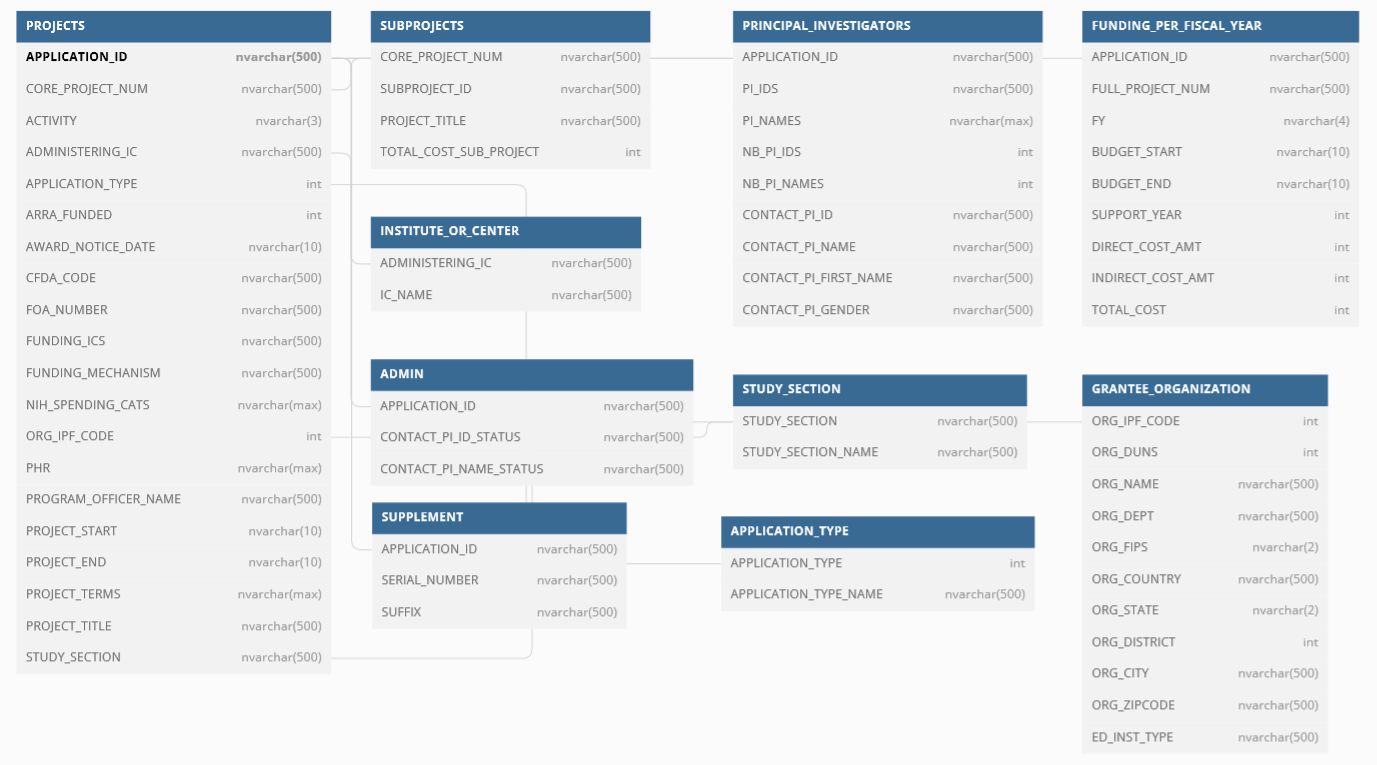

## Field max length

Check longest value in a cell to make sure import in SQL doesn't crash.

In [52]:
def get_longest_item_in_tsv_column(filepath, column):
    '''
    Returns the longest line in a given file.
    '''

    with open(filepath, 'r', encoding=OUTPUT_ENCODING, newline=NEWLINE) as input_file:
        reader = csv.DictReader(input_file, delimiter=DELIMITER)
        
        longest_item = max((len(row[column]) for row in reader))
        
        return longest_item        

In [32]:
# Pretty inefficient and long to run - only run once a year when adding new data

# fieldnames=[
#         APPLICATION_ID,
#         ACTIVITY,
#         ADMINISTERING_IC,
#         APPLICATION_TYPE,
#         APPLICATION_TYPE_NAME,
#         ARRA_FUNDED,
#         AWARD_NOTICE_DATE,
#         BUDGET_START,
#         BUDGET_END,
#         CFDA_CODE,
#         CORE_PROJECT_NUM,
#         ED_INST_TYPE,
#         FOA_NUMBER,
#         FULL_PROJECT_NUM,
#         FUNDING_ICS,
#         FUNDING_MECHANISM,
#         FY,
#         IC_NAME,
#         NIH_SPENDING_CATS,
#         ORG_CITY,
#         ORG_COUNTRY,
#         ORG_DEPT,
#         ORG_DISTRICT,
#         ORG_DUNS,
#         ORG_FIPS,
#         ORG_IPF_CODE,
#         ORG_NAME,
#         ORG_STATE,
#         ORG_ZIPCODE,
#         PHR,
#         PI_IDS,
#         PI_NAMES,
#         NB_PI_IDS,
#         NB_PI_NAMES,
#         CONTACT_PI_ID, 
#         CONTACT_PI_NAME, 
#         CONTACT_PI_ID_STATUS, 
#         CONTACT_PI_NAME_STATUS,
#         CONTACT_PI_FIRST_NAME,
#         CONTACT_PI_GENDER,
#         PROGRAM_OFFICER_NAME,
#         PROJECT_START,
#         PROJECT_END,
#         PROJECT_TERMS,
#         PROJECT_TITLE,
#         SERIAL_NUMBER,
#         STUDY_SECTION,
#         STUDY_SECTION_NAME,
#         SUBPROJECT_ID,
#         SUFFIX,
#         SUPPORT_YEAR,
#         DIRECT_COST_AMT,
#         INDIRECT_COST_AMT,
#         TOTAL_COST,
#         TOTAL_COST_SUB_PROJECT
#     ]

# for fieldname in fieldnames:
#     print(fieldname + ': ')
#     print(get_longest_item_in_tsv_column(ENHANCED_FILE, fieldname))
#     print('----------------')

APPLICATION_ID: 
8
----------------
ACTIVITY: 
3
----------------
ADMINISTERING_IC: 
2
----------------
APPLICATION_TYPE: 
1
----------------
APPLICATION_TYPE_NAME: 
96
----------------
ARRA_FUNDED: 
1
----------------
AWARD_NOTICE_DATE: 
19
----------------
BUDGET_START: 
10
----------------
BUDGET_END: 
10
----------------
CFDA_CODE: 
23
----------------
CORE_PROJECT_NUM: 
32
----------------
ED_INST_TYPE: 
70
----------------
FOA_NUMBER: 
14
----------------
FULL_PROJECT_NUM: 
37
----------------
FUNDING_ICS: 
295
----------------
FUNDING_MECHANISM: 
23
----------------
FY: 
4
----------------
IC_NAME: 
79
----------------
NIH_SPENDING_CATS: 
2232
----------------
ORG_CITY: 
27
----------------
ORG_COUNTRY: 
14
----------------
ORG_DEPT: 
30
----------------
ORG_DISTRICT: 
2
----------------
ORG_DUNS: 
75
----------------
ORG_FIPS: 
2
----------------
ORG_IPF_CODE: 
8
----------------
ORG_NAME: 
92
----------------
ORG_STATE: 
2
----------------
ORG_ZIPCODE: 
10
----------------
PHR

| Fieldname | Longest line lenght |
| :--- | :--- |
| APPLICATION_ID | 8 |
| ACTIVITY | 3 |
| ADMINISTERING_IC | 2 |
| APPLICATION_TYPE | 1 |
| APPLICATION_TYPE_NAME | 96 |
| ARRA_FUNDED | 1 |
| AWARD_NOTICE_DATE | 19 |
| BUDGET_START | 10 |
| BUDGET_END | 10 |
| CFDA_CODE | 23 |
| CORE_PROJECT_NUM | 32 |
| ED_INST_TYPE | 70 |
| FOA_NUMBER | 14 |
| FULL_PROJECT_NUM | 37 |
| FUNDING_ICS | 295 |
| FUNDING_MECHANISM | 23 |
| FY | 4 |
| IC_NAME | 79 |
| NIH_SPENDING_CATS | 2232 |
| ORG_CITY | 27 |
| ORG_COUNTRY | 14 |
| ORG_DEPT | 30 |
| ORG_DISTRICT | 2 |
| ORG_DUNS | 75 |
| ORG_FIPS | 2 |
| ORG_IPF_CODE | 8 |
| ORG_NAME | 92 |
| ORG_STATE | 2 |
| ORG_ZIPCODE | 10 |
| PHR | 32003 |
| PI_IDS | 262 |
| PI_NAMES | 533 |
| NB_PI_IDS | 2 |
| NB_PI_NAMES | 2 |
| CONTACT_PI_ID | 18 |
| CONTACT_PI_NAME | 54 |
| CONTACT_PI_ID_STATUS | 43 |
| CONTACT_PI_NAME_STATUS | 52 |
| CONTACT_PI_FIRST_NAME | 33 |
| CONTACT_PI_GENDER | 1 |
| PROGRAM_OFFICER_NAME | 39 |
| PROJECT_START | 10 |
| PROJECT_END | 10 |
| PROJECT_TERMS | 32767 |
| PROJECT_TITLE | 200 |
| SERIAL_NUMBER | 6 |
| STUDY_SECTION | 4 |
| STUDY_SECTION_NAME | 116 |
| SUBPROJECT_ID | 4 |
| SUFFIX | 6 |
| SUPPORT_YEAR | 2 |
| DIRECT_COST_AMT | 9 |
| INDIRECT_COST_AMT | 8 |
| TOTAL_COST | 9 |
| TOTAL_COST_SUB_PROJECT | 8 |

# Create the tables

## Split enhanced output file into different tables according to database design

In [3]:
def is_not_duplicated(row):
    return row['APPLICATION_ID'] != '7916889' 
    # there was 1 duplicated application_id (supposed to be unique), so I removed both rows to prevent SQL import from crashing


def filter_columns(
    source_file, target_file, subset_headers, 
    default_row_filter=is_not_duplicated, row_filter=lambda row: True):
    
    subset_headers_set = set(subset_headers)
    
    with open(source_file, 'r', encoding=OUTPUT_ENCODING, newline=NEWLINE) as csv_file_descriptor:
        reader = csv.DictReader(csv_file_descriptor, delimiter=DELIMITER)

        with open(target_file, 'w', encoding=OUTPUT_ENCODING, newline=NEWLINE) as output_file:
            writer = csv.DictWriter(output_file, fieldnames=subset_headers, delimiter=DELIMITER)
            writer.writeheader()

            for row in reader:
                if default_row_filter(row) == False:
                    continue
                    
                if row_filter(row) == False:
                    continue
                
                subset_row = {}
                for key, value in row.items():
                    if key in subset_headers_set:
                        subset_row[key] = value
                writer.writerow(subset_row)

In [4]:
# First test for SQL import with only a few columns
# In command line, go to the right folder and run `head -n 5 test.tsv > test_head.tsv` to output only the first 5 rows
# Use `test_head.tsv` to try the import in SQL
filter_columns(ENHANCED_FILE, TABLE_DIR + 'test.tsv', [
    APPLICATION_ID, # use as primary key 
    APPLICATION_TYPE, 
    PHR])

In [54]:
# TABLE PROJECTS
filter_columns(ENHANCED_FILE, TABLE_DIR + 'PROJECTS.tsv', [
    APPLICATION_ID, # use as primary key
    CORE_PROJECT_NUM, 
    ACTIVITY, 
    ADMINISTERING_IC, 
    APPLICATION_TYPE, 
    ARRA_FUNDED, 
    AWARD_NOTICE_DATE, 
    CFDA_CODE, 
    FOA_NUMBER, 
    FUNDING_ICS, 
    FUNDING_MECHANISM, 
    NIH_SPENDING_CATS, 
    ORG_IPF_CODE, 
    PHR, 
    PROGRAM_OFFICER_NAME, 
    PROJECT_START, 
    PROJECT_END, 
    PROJECT_TERMS, 
    PROJECT_TITLE,  
    STUDY_SECTION])

In [55]:
# TABLE SUBPROJECTS
filter_columns(ENHANCED_FILE, TABLE_DIR + 'SUBPROJECTS.tsv', [
    CORE_PROJECT_NUM,
    SUBPROJECT_ID, 
    PROJECT_TITLE, 
    TOTAL_COST_SUB_PROJECT], 
                 row_filter=lambda row: row[SUBPROJECT_ID] != "" and row[SUBPROJECT_ID] is not None)

In [56]:
# TABLE APPLICATION_TYPE
filter_columns(ENHANCED_FILE, TABLE_DIR + 'APPLICATION_TYPE.tsv', [
    APPLICATION_TYPE, 
    APPLICATION_TYPE_NAME])

In [57]:
# TABLE PRINCIPAL_INVESTIGATORS
filter_columns(ENHANCED_FILE, TABLE_DIR + 'PRINCIPAL_INVESTIGATORS.tsv', [
    APPLICATION_ID, 
    PI_IDS, 
    PI_NAMES, 
    NB_PI_IDS, 
    NB_PI_NAMES, 
    CONTACT_PI_ID, 
    CONTACT_PI_NAME, 
    CONTACT_PI_FIRST_NAME, 
    CONTACT_PI_GENDER])

In [58]:
# TABLE FUNDING_PER_FISCAL_YEAR
filter_columns(ENHANCED_FILE, TABLE_DIR + 'FUNDING_PER_FISCAL_YEAR.tsv', [
    APPLICATION_ID, 
    FULL_PROJECT_NUM, 
    FY, 
    BUDGET_START, 
    BUDGET_END, 
    SUPPORT_YEAR, 
    DIRECT_COST_AMT, 
    INDIRECT_COST_AMT, 
    TOTAL_COST])

In [59]:
# TABLE GRANTEE_ORGANIZATION
filter_columns(ENHANCED_FILE, TABLE_DIR + 'GRANTEE_ORGANIZATION.tsv', [
    ORG_IPF_CODE, 
    ORG_DUNS, 
    ORG_NAME, 
    ORG_DEPT, 
    ORG_FIPS, 
    ORG_COUNTRY, 
    ORG_STATE, 
    ORG_DISTRICT, 
    ORG_CITY, 
    ORG_ZIPCODE, 
    ED_INST_TYPE])

In [60]:
# TABLE INSTITUTE_OR_CENTER
filter_columns(ENHANCED_FILE, TABLE_DIR + 'INSTITUTE_OR_CENTER.tsv', [
    ADMINISTERING_IC, 
    IC_NAME])

In [61]:
# TABLE STUDY_SECTION
filter_columns(ENHANCED_FILE, TABLE_DIR + 'STUDY_SECTION.tsv', [
    STUDY_SECTION, 
    STUDY_SECTION_NAME])

In [62]:
# TABLE SUPPLEMENT - for useless fields that we still want to keep
filter_columns(ENHANCED_FILE, TABLE_DIR + 'SUPPLEMENT.tsv', [
    APPLICATION_ID,
    SERIAL_NUMBER,
    SUFFIX])

In [63]:
# TABLE ADMIN - for more information on the output of the gender identification
filter_columns(ENHANCED_FILE, TABLE_DIR + 'ADMIN.tsv', [
    APPLICATION_ID,
    CONTACT_PI_ID_STATUS, 
    CONTACT_PI_NAME_STATUS])

## QA

In [64]:
# Take a look at the different tables to make sure they contain the right data
test_df = pd.read_csv(TABLE_DIR + 'PRINCIPAL_INVESTIGATORS.tsv', 
                      delimiter=DELIMITER, encoding=OUTPUT_ENCODING, low_memory=False)
test_df.head()

,APPLICATION_ID,PI_IDS,PI_NAMES,NB_PI_IDS,NB_PI_NAMES,CONTACT_PI_ID,CONTACT_PI_NAME,CONTACT_PI_FIRST_NAME,CONTACT_PI_GENDER
0,10229388,1902986;,"PERLMAN, STANLEY ;",1,1,1902986,"PERLMAN, STANLEY",STANLEY,M
1,10229500,1869110;,"SEMPOWSKI, GREGORY D;",1,1,1869110,"SEMPOWSKI, GREGORY D",GREGORY,M
2,10234175,11404564;,"NEUNUEBEL, MARIA RAMONA;",1,1,11404564,"NEUNUEBEL, MARIA RAMONA",MARIA RAMONA,NaN
3,10107767,11433979 (contact); 12250285;,"LAVINE, KORY J. (contact); STURGEON, CHRISTOPH...",2,2,11433979 (contact),"LAVINE, KORY J. (contact)",KORY,M
4,10144347,1861963;,"GANGULI, MARY ;",1,1,1861963,"GANGULI, MARY",MARY,F


In [65]:
test_df.duplicated(subset=['APPLICATION_ID']).value_counts()

False    2621672
dtype: int64

In [23]:
# test_df[test_df.duplicated(['APPLICATION_ID'], keep=False)]

## Import each table into Microsoft SQL Management Studio

Now, you should sync with OST and if needed ask for help with the import.

Good luck!